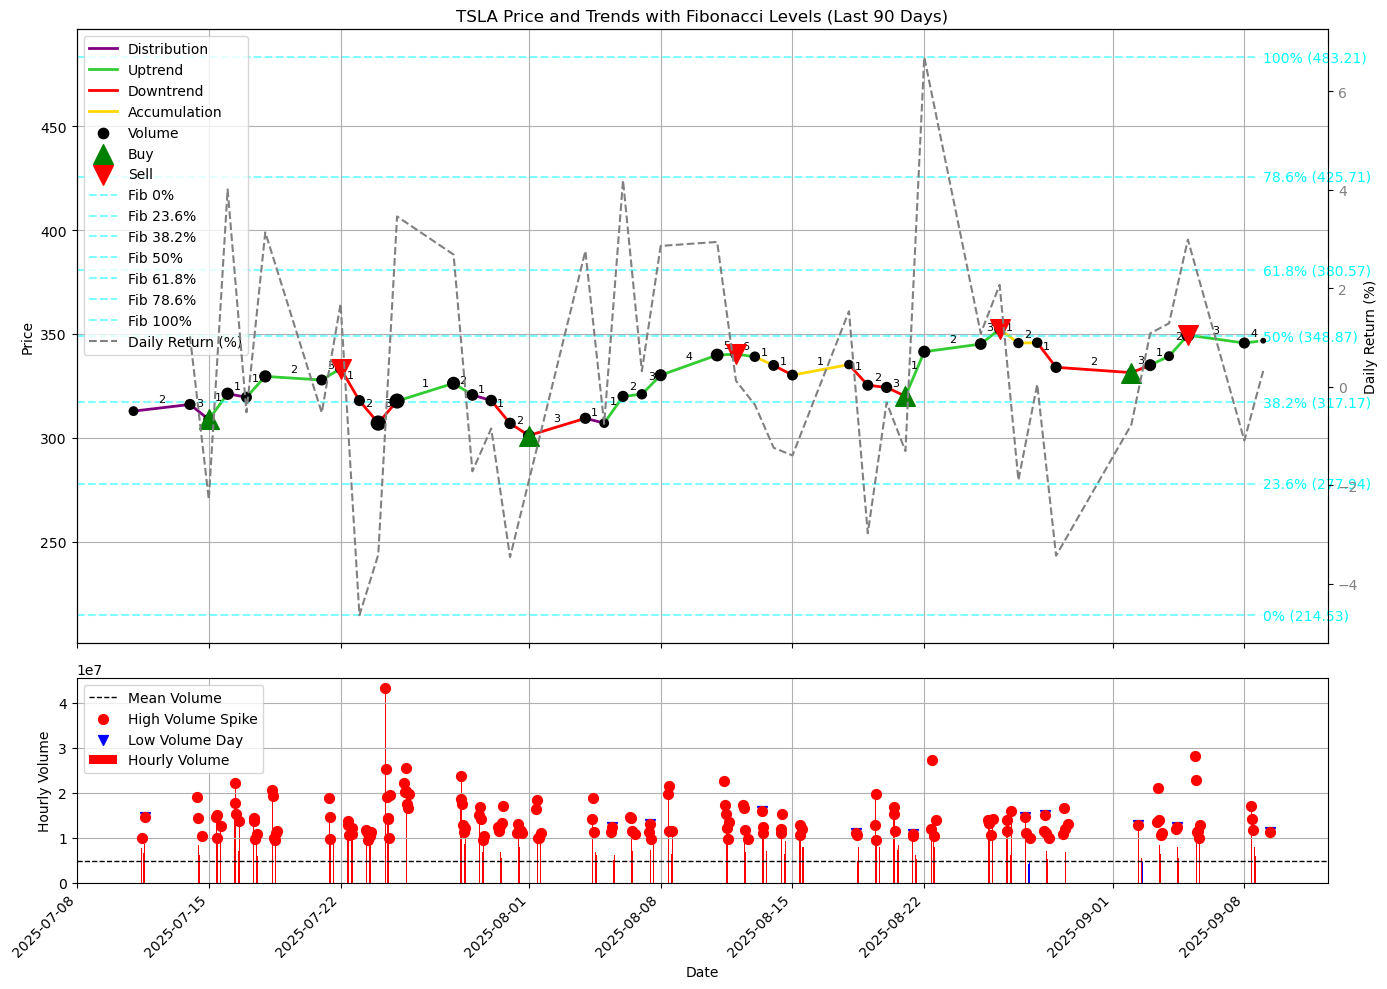

In [2]:
# Import libraries (unchanged)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.signal import argrelextrema

import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)


# Step 1: Pull last 90 days of stock data (improved with fallback interval)
def get_stock_data(ticker, days=365, interval="5m"):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    stock = yf.Ticker(ticker)
    
    # Try the specified interval first
    try:
        df = stock.history(interval=interval, start=start_date, end=end_date, prepost=True)
        if df.empty:
            print(f"No intraday data available for {ticker} with interval {interval}. Trying 1-hour interval.")
            df = stock.history(interval="1h", start=start_date, end=end_date, prepost=True)
            if df.empty:
                print(f"No intraday data available for {ticker} with interval 1h. Falling back to daily data.")
                df = stock.history(start=start_date, end=end_date)
                return df, False
            return df, True
        return df, True
    except Exception as e:
        print(f"Error fetching intraday data for {ticker} with interval {interval}: {e}. Trying 1-hour interval.")
        try:
            df = stock.history(interval="1h", start=start_date, end=end_date, prepost=True)
            if df.empty:
                print(f"No intraday data available for {ticker} with interval 1h. Falling back to daily data.")
                df = stock.history(start=start_date, end=end_date)
                return df, False
            return df, True
        except Exception as e2:
            print(f"Error fetching intraday data for {ticker} with interval 1h: {e2}. Falling back to daily data.")
            df = stock.history(start=start_date, end=end_date)
            return df, False

# Step 2: Aggregate intraday data to daily data (unchanged)
def aggregate_to_daily(df, is_intraday=True):
    if not is_intraday or df.empty:
        if df.empty:
            print("Empty DataFrame received. Returning empty DataFrame with expected columns.")
            return pd.DataFrame(columns=['Close', 'Daily_Return', 'Pre_Market_Return', 
                                        'After_Hours_Return', 'Low', 'High', 'Volume']), df
        df['Daily_Return'] = df['Close'].pct_change()
        df['Pre_Market_Return'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
        df['After_Hours_Return'] = 0.0
        return df, df
    
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    df['Is_Regular_Hours'] = (df.index.time >= pd.Timestamp('09:30:00').time()) & \
                             (df.index.time <= pd.Timestamp('16:00:00').time())
    
    daily_data = df.groupby('Date').agg({
        'Close': 'last',
        'Low': 'min',
        'High': 'max',
        'Volume': 'sum'
    }).reset_index()
    
    daily_data['Date'] = pd.to_datetime(daily_data['Date'])
    daily_data.set_index('Date', inplace=True)
    
    df['Session'] = 'Regular'
    df.loc[(df.index.time < pd.Timestamp('09:30:00').time()), 'Session'] = 'Pre_Market'
    df.loc[(df.index.time > pd.Timestamp('16:00:00').time()), 'Session'] = 'After_Hours'
    
    pre_market = df[df['Session'] == 'Pre_Market'].groupby('Date')['Close'].last()
    after_hours = df[df['Session'] == 'After_Hours'].groupby('Date')['Close'].first()
    regular_open = df[df['Time'] == pd.Timestamp('09:30:00').time()].groupby('Date')['Close'].first()
    regular_close = df[df['Time'] == pd.Timestamp('16:00:00').time()].groupby('Date')['Close'].first()
    
    daily_data['Pre_Market_Return'] = np.nan
    daily_data['After_Hours_Return'] = np.nan
    
    for date in daily_data.index:
        prev_date = daily_data.index[daily_data.index < date]
        if len(prev_date) > 0:
            prev_date = prev_date[-1]
            prev_close = daily_data.loc[prev_date, 'Close']
            
            if date.date() in pre_market.index and not pd.isna(prev_close):
                pre_market_price = pre_market[date.date()]
                daily_data.loc[date, 'Pre_Market_Return'] = (pre_market_price - prev_close) / prev_close
            
            if date.date() in after_hours.index and date.date() in regular_close.index:
                after_hours_price = after_hours[date.date()]
                reg_close_price = regular_close[date.date()]
                if not pd.isna(reg_close_price):
                    daily_data.loc[date, 'After_Hours_Return'] = (after_hours_price - reg_close_price) / reg_close_price
    
    daily_data['Daily_Return'] = daily_data['Close'].pct_change()
    
    return daily_data, df

# Step 3: Identify trading points (unchanged)
def identify_trading_points(stock_data, investment=10000, buy_percentage=0.5, sell_percentage=0.5, strategy="default"):
    stock_data = stock_data.copy()
    stock_data = stock_data.dropna(subset=['Close'])
    if stock_data.empty:
        raise ValueError("No valid price data available after dropping NaN values.")

    order_lookback = 5
    stock_data['Min'] = stock_data.iloc[argrelextrema(stock_data['Close'].values, np.less_equal, order=order_lookback)[0]]['Close']
    stock_data['Max'] = stock_data.iloc[argrelextrema(stock_data['Close'].values, np.greater_equal, order=order_lookback)[0]]['Close']

    position = 0
    cash = investment
    cost_basis = 0
    average_cost_basis = 0
    total_profit = 0
    principal = investment
    trading_log = []

    initial_price = stock_data['Close'].iloc[0]
    if pd.isna(initial_price):
        raise ValueError("Initial price is NaN. Cannot proceed with trading simulation.")
    shares_bought = int((cash * buy_percentage) // initial_price)
    cost_basis = initial_price
    average_cost_basis = cost_basis
    cash -= shares_bought * cost_basis
    position += shares_bought
    transaction_principal = shares_bought * cost_basis
    trading_log.append({
        'Date': stock_data.index[0],
        'Action': 'Initial Buy',
        'Shares': shares_bought,
        'Price': cost_basis,
        'Cash After': cash,
        'Cost Basis': cost_basis,
        'Average Cost Basis': average_cost_basis,
        'Profit/Loss': 0,
        'Total Profit': total_profit,
        'Principal': principal,
        'Transaction Principal': transaction_principal
    })

    for i in range(1, len(stock_data)):
        if not pd.isna(stock_data['Min'].iloc[i]) and cash > 0:
            shares_bought = int((cash * buy_percentage) // stock_data['Close'].iloc[i])
            cost_basis = stock_data['Close'].iloc[i]
            average_cost_basis = ((position * average_cost_basis) + (shares_bought * cost_basis)) / (position + shares_bought)
            cash -= shares_bought * cost_basis
            position += shares_bought
            transaction_principal = shares_bought * cost_basis
            trading_log.append({
                'Date': stock_data.index[i],
                'Action': 'Buy',
                'Shares': shares_bought,
                'Price': cost_basis,
                'Cash After': cash,
                'Cost Basis': cost_basis,
                'Average Cost Basis': average_cost_basis,
                'Profit/Loss': 0,
                'Total Profit': total_profit,
                'Principal': principal,
                'Transaction Principal': transaction_principal
            })
        elif not pd.isna(stock_data['Max'].iloc[i]) and position > 0:
            shares_to_sell = int(position * sell_percentage)
            sell_price = stock_data['Close'].iloc[i]
            profit = (sell_price - average_cost_basis) * shares_to_sell
            total_profit += profit
            cash += shares_to_sell * sell_price
            principal += profit
            transaction_principal = shares_to_sell * sell_price
            trading_log.append({
                'Date': stock_data.index[i],
                'Action': 'Sell',
                'Shares': shares_to_sell,
                'Price': sell_price,
                'Cash After': cash,
                'Cost Basis': cost_basis,
                'Average Cost Basis': average_cost_basis,
                'Profit/Loss': profit,
                'Total Profit': total_profit,
                'Principal': principal,
                'Transaction Principal': transaction_principal
            })
            position -= shares_to_sell

    return pd.DataFrame(trading_log), stock_data

# Step 4: Classify trends and prepare DataFrame (unchanged)
def prepare_dataframe(df):
    if df.empty:
        print("Empty DataFrame after aggregation. Returning empty DataFrame with expected columns.")
        return pd.DataFrame(columns=['Price', 'Daily_Return', 'Pre_Market_Return', 
                                    'After_Hours_Return', 'Lowest_Price', 'Highest_Price', 
                                    'Trend', 'Trend_Days', 'Days_To_Optimal', 'Volume']), pd.DataFrame()
    
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=3).std()
    df['Avg_Return'] = df['Returns'].rolling(window=3).mean()
    df['Trend'] = ''
    df['Trend_Days'] = 0
    
    df['Volatility'] = df['Volatility'].fillna(df['Volatility'].mean())
    df['Avg_Return'] = df['Avg_Return'].fillna(0)
    
    for i in range(len(df)):
        avg_return = df['Avg_Return'].iloc[i]
        volatility = df['Volatility'].iloc[i]
        volatility_threshold = df['Volatility'].mean()
        
        if avg_return > 0.005:
            df['Trend'].iloc[i] = 'Uptrend'
        elif avg_return < -0.005:
            df['Trend'].iloc[i] = 'Downtrend'
        elif abs(avg_return) <= 0.005 and volatility < volatility_threshold:
            df['Trend'].iloc[i] = 'Accumulation'
        else:
            df['Trend'].iloc[i] = 'Distribution'
        
        if i > 0 and df['Trend'].iloc[i] == df['Trend'].iloc[i-1]:
            df['Trend_Days'].iloc[i] = df['Trend_Days'].iloc[i-1] + 1
        else:
            df['Trend_Days'].iloc[i] = 1
    
    trading_log, df_with_extrema = identify_trading_points(df)
    
    df['Local_Min'] = df_with_extrema['Min']
    df['Local_Max'] = df_with_extrema['Max']
    
    df['Days_To_Optimal'] = np.nan
    optimal_dates = df[(df['Local_Min'].notna()) | (df['Local_Max'].notna())].index
    
    for i in range(len(df)):
        current_date = df.index[i]
        current_trend = df['Trend'].iloc[i]
        
        trend_start_idx = i - df['Trend_Days'].iloc[i]
        trend_dates = df.index[trend_start_idx:i+1]
        future_dates = optimal_dates[optimal_dates > current_date]
        past_dates = optimal_dates[optimal_dates < current_date]
        
        if len(past_dates) > 0:
            past_optimal = past_dates[-1]
            if df.index.get_loc(past_optimal) >= trend_start_idx:
                days_from = (current_date - past_optimal).days
                df['Days_To_Optimal'].iloc[i] = -days_from
        
        if len(future_dates) > 0 and pd.isna(df['Days_To_Optimal'].iloc[i]):
            future_optimal = future_dates[0]
            future_trend = df.loc[future_optimal, 'Trend']
            if current_trend == future_trend:
                days_to = (future_optimal - current_date).days
                df['Days_To_Optimal'].iloc[i] = days_to
    
    final_df = df[['Close', 'Daily_Return', 'Pre_Market_Return', 'After_Hours_Return', 
                   'Low', 'High', 'Trend', 'Trend_Days', 'Days_To_Optimal', 'Volume']].copy()
    final_df.rename(columns={'Close': 'Price', 'Low': 'Lowest_Price', 'High': 'Highest_Price'}, inplace=True)
    
    return final_df, trading_log

# Fibonacci levels calculation (unchanged, already correct)
def calculate_fibonacci_levels(df):
    """
    Calculate Fibonacci retracement levels based on the highest and lowest prices in the dataset.
    Returns a dictionary with levels (0%, 23.6%, 38.2%, 50%, 61.8%, 78.6%, 100%).
    """
    if df.empty or 'Highest_Price' not in df.columns or 'Lowest_Price' not in df.columns:
        return {}
    
    high_price = df['Highest_Price'].max()
    low_price = df['Lowest_Price'].min()
    price_range = high_price - low_price
    
    fib_levels = {
        '0%': low_price,
        '23.6%': low_price + 0.236 * price_range,
        '38.2%': low_price + 0.382 * price_range,
        '50%': low_price + 0.5 * price_range,
        '61.8%': low_price + 0.618 * price_range,
        '78.6%': low_price + 0.786 * price_range,
        '100%': high_price
    }
    
    return fib_levels

# Updated visualize_trends with secondary y-axis for percentage returns
def visualize_trends(df, ticker, trading_log, intraday_df, is_intraday=True, show_fibonacci=True):
    if df.empty:
        print("Cannot visualize: DataFrame is empty.")
        return
    
    # Create a figure with two subplots (price on top, volume below)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # --- Price Plot (Top Subplot) ---
    # Define high-contrast colors for trends
    colors = {
        'Uptrend': 'limegreen',
        'Downtrend': 'red',
        'Accumulation': 'gold',
        'Distribution': 'purple'
    }
    
    # Plot the price line as segments and add Days in Trend annotations
    for i in range(1, len(df)):
        start_date = df.index[i-1]
        end_date = df.index[i]
        start_price = df['Price'].iloc[i-1]
        end_price = df['Price'].iloc[i]
        trend = df['Trend'].iloc[i]
        days_in_trend = df['Trend_Days'].iloc[i]
        
        ax1.plot([start_date, end_date], [start_price, end_price], 
                 color=colors[trend], linewidth=2, 
                 label=trend if trend not in ax1.get_legend_handles_labels()[1] else "")
        
        mid_date = start_date + (end_date - start_date) / 2
        mid_price = (start_price + end_price) / 2
        ax1.text(mid_date, mid_price + 2, str(days_in_trend), 
                 fontsize=8, ha='center', va='bottom', color='black')
    
    # Add volume-scaled dots for each trading day
    if 'Volume' in df.columns and not df['Volume'].isna().all():
        min_volume = df['Volume'].min()
        max_volume = df['Volume'].max()
        if max_volume > min_volume:
            volume_scaled = 10 + 90 * (df['Volume'] - min_volume) / (max_volume - min_volume)
        else:
            volume_scaled = pd.Series([50] * len(df), index=df.index)
        
        ax1.scatter(df.index, df['Price'], s=volume_scaled, color='black', 
                    label='Volume' if 'Volume' not in ax1.get_legend_handles_labels()[1] else "", zorder=5)
    
    # Plot buy/sell markers
    for _, row in trading_log.iterrows():
        if row['Action'] == 'Buy':
            ax1.scatter(row['Date'], row['Price'], color='green', marker='^', s=200, 
                        label='Buy' if 'Buy' not in ax1.get_legend_handles_labels()[1] else "", zorder=10)
        elif row['Action'] == 'Sell':
            ax1.scatter(row['Date'], row['Price'], color='red', marker='v', s=200, 
                        label='Sell' if 'Sell' not in ax1.get_legend_handles_labels()[1] else "", zorder=10)
    
    # Add Fibonacci retracement levels if toggled on
    if show_fibonacci:
        fib_levels = calculate_fibonacci_levels(df)
        if fib_levels:
            for level, price in fib_levels.items():
                ax1.axhline(y=price, color='cyan', linestyle='--', alpha=0.5, 
                            label=f'Fib {level}' if f'Fib {level}' not in ax1.get_legend_handles_labels()[1] else "")
                # Add text label at the right edge of the plot
                ax1.text(df.index[-1], price, f'{level} ({price:.2f})', 
                         fontsize=10, va='center', ha='left', color='cyan', 
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Add secondary y-axis for daily returns
    ax1b = ax1.twinx()
    ax1b.plot(df.index, df['Daily_Return'] * 100, color='gray', linestyle='--', alpha=1.0, label='Daily Return (%)')
    ax1b.set_ylabel('Daily Return (%)', color='black')
    ax1b.tick_params(axis='y', labelcolor='gray')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax1.set_title(f'{ticker} Price and Trends{" with Fibonacci Levels" if show_fibonacci else ""} (Last 90 Days)')
    ax1.set_ylabel('Price')
    ax1.grid()
    
    # --- Intraday Volume Plot (Bottom Subplot) ---
    if is_intraday and not intraday_df.empty and 'Volume' in intraday_df.columns:
        # Aggregate intraday volume to hourly intervals
        intraday_df['Hour'] = intraday_df.index.floor('H')
        hourly_volume = intraday_df.groupby('Hour')['Volume'].sum().reset_index()
        
        # Calculate mean hourly volume to identify spikes
        mean_volume = hourly_volume['Volume'].mean()
        
        # Color bars based on volume (blue for low, red for spikes)
        colors = ['blue' if vol <= mean_volume else 'red' for vol in hourly_volume['Volume']]
        
        # Plot hourly volume as a bar chart
        ax2.bar(hourly_volume['Hour'], hourly_volume['Volume'], width=0.02, color=colors, label='Hourly Volume')
        ax2.axhline(mean_volume, color='black', linestyle='--', linewidth=1, label='Mean Volume')
        
        # Identify high volume spikes (above 75th percentile)
        high_volume_threshold = hourly_volume['Volume'].quantile(0.75)
        high_volume_spikes = hourly_volume[hourly_volume['Volume'] > high_volume_threshold]
        
        # Add dots for high volume spikes
        ax2.scatter(high_volume_spikes['Hour'], high_volume_spikes['Volume'], 
                    color='red', marker='o', s=50, label='High Volume Spike', zorder=5)
        
        # Aggregate hourly volume to daily totals to identify low volume days
        daily_volume = intraday_df.groupby(intraday_df.index.date)['Volume'].sum().reset_index()
        daily_volume['Date'] = pd.to_datetime(daily_volume['index'])
        daily_volume = daily_volume.drop(columns=['index'])
        
        # Identify low volume days (below 25th percentile)
        low_volume_threshold = daily_volume['Volume'].quantile(0.25)
        low_volume_days = daily_volume[daily_volume['Volume'] < low_volume_threshold]
        
        # Add markers for low volume days
        for _, row in low_volume_days.iterrows():
            day_volumes = hourly_volume[hourly_volume['Hour'].dt.date == row['Date'].date()]
            if not day_volumes.empty:
                max_volume = day_volumes['Volume'].max()
                marker_date = day_volumes.loc[day_volumes['Volume'].idxmax(), 'Hour']
                ax2.scatter(marker_date, max_volume, 
                            color='blue', marker='v', s=50, 
                            label='Low Volume Day' if 'Low Volume Day' not in ax2.get_legend_handles_labels()[1] else "", zorder=3)
        
        ax2.set_ylabel('Hourly Volume')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid()
        
        # Rotate x-axis labels for better readability
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    else:
        ax2.text(0.5, 0.5, 'Intraday volume data not available', 
                 ha='center', va='center', transform=ax2.transAxes)
        ax2.set_ylabel('Hourly Volume')
        ax2.set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()

# Main execution (unchanged)
if __name__ == "__main__":
    ticker = 'TSLA'
    df, is_intraday = get_stock_data(ticker, days=60, interval="5m")
    daily_df, intraday_df = aggregate_to_daily(df, is_intraday)
    final_df, trading_log = prepare_dataframe(daily_df)
    visualize_trends(final_df, ticker, trading_log, intraday_df, is_intraday, show_fibonacci=True)

In [10]:
print("\nPrepared DataFrame:")
final_df


Prepared DataFrame:


,Price,Daily_Return,Pre_Market_Return,After_Hours_Return,Lowest_Price,Highest_Price,Trend,Trend_Days,Days_To_Optimal,Volume
Date,,,,,,,,,,
2025-06-13,18.4700,NaN,NaN,NaN,18.100000,21.399900,Accumulation,1,NaN,2643887
2025-06-16,21.0600,0.140227,0.027287,0.000000,18.380000,21.900000,Accumulation,2,-3.0,2733984
2025-06-17,21.7400,0.032289,0.014245,-0.001377,20.931101,22.200001,Accumulation,3,-4.0,1678204
2025-06-18,24.1600,0.111316,0.003910,-0.018152,21.500000,24.240000,Uptrend,1,8.0,2817590
2025-06-20,25.8699,0.070774,0.016142,0.000000,23.828700,27.040001,Uptrend,2,6.0,3904130
2025-06-23,28.6100,0.105918,-0.014298,-0.003676,22.590000,28.630000,Uptrend,3,3.0,3145370
2025-06-24,29.0500,0.015379,-0.000350,0.007725,23.828100,29.809999,Uptrend,4,2.0,2765449
2025-06-25,27.2700,-0.061274,-0.005852,0.028185,26.750000,29.290000,Uptrend,5,1.0,2445778
2025-06-26,31.0700,0.139347,0.024569,0.000000,27.279900,31.940001,Uptrend,6,NaN,3306762


In [11]:
print("\nTrading Log:")
trading_log


Trading Log:


,Date,Action,Shares,Price,Cash After,Cost Basis,Average Cost Basis,Profit/Loss,Total Profit,Principal,Transaction Principal
0,2025-06-13,Initial Buy,270,18.4700,5013.1000,18.4700,18.470000,0.0,0.0,10000.0,4986.9000
1,2025-06-26,Sell,135,31.0700,9207.5500,18.4700,18.470000,1701.0,1701.0,11701.0,4194.4500
2,2025-07-11,Buy,225,20.4003,4617.4825,20.4003,19.676437,0.0,1701.0,11701.0,4590.0675
